This is a project by Sara Nimje - ssnimjee_b22@et.vjti.ac.in
https://colab.research.google.com/drive/1wcp6x-kXMvr6DuOCHzQwPwLC7Lopsj7q?usp=sharing

## Getting Started

In [1]:
!pip install transformers torch nltk feedparser googlesearch-python scikit-learn gensim pandas==2.2.2

In [2]:
import feedparser
import pandas as pd
import numpy as np
from transformers import pipeline
import requests
from bs4 import BeautifulSoup
import httpx
import concurrent.futures
from googlesearch import search
import re
import nltk
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import spacy
from collections import Counter
import json
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Extracting Data

In [3]:
# List of social media and non-news websites to exclude
excluded_domains = [
    "youtube.com", "en.wikipedia.org", "m.economictimes.com", "www.prnewswire.com",
    "economictimes.indiatimes.com", "www.moneycontrol.com"
]


In [4]:
def get_top_articles(company_name):
    """Search for company news using Google."""
    query = f"{company_name} news"
    return [url for url in search(query, num_results=25)]

def is_valid_news_article(url, company_name):
    """Check if the URL is a valid news article and not an official company website or social media."""
    try:
        domain = url.split('/')[2]
        if company_name.lower() in domain.lower() or any(excluded_domain in domain for excluded_domain in excluded_domains):
            return False
        return True
    except IndexError:
        return False  # Skip invalid URLs

In [5]:
def extract_article_data(url):
    """Extract article title, link, and website name from a valid URL."""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Handle HTTP errors

        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract article title
        title = soup.title.string.strip() if soup.title else None
        source = url.split('/')[2]  # Extract domain

        # Validate extracted data
        if not title or not source:
            return None

        return {"title": title, "link": url, "source": source}

    except (requests.exceptions.RequestException, AttributeError):
        return None  # Skip articles with invalid data

In [6]:
def main(company_name):
    """Fetch and process valid news articles for the given company."""
    urls = get_top_articles(company_name)

    # Filter out invalid URLs
    valid_urls = [url for url in urls if is_valid_news_article(url, company_name)]

    # Extract and validate article data
    articles_data = [extract_article_data(url) for url in valid_urls]
    articles_data = [article for article in articles_data if article]  # Remove None values

    # Create DataFrame only if valid articles exist
    if articles_data:
        df = pd.DataFrame(articles_data)
    else:
        df = pd.DataFrame(columns=["title", "link"])  # Empty DataFrame

    return df

In [7]:
company_name = input('Give name of company: ')
df = main(company_name)

Give name of company: Zomato


In [8]:
df

title  \
0  IAS officer emails B-school alumni list over Z...   
1  Zomato share price surges over 6% despite poss...   
2  People Matters - Interstitial Site — People Ma...   
3  People Matters - Interstitial Site — People Ma...   
4  Zomato Quick's 'Ek Do Teen' remix stops at 'Du...   
5  Latest News on Zomato: Get Zomato News Updates...   
6  Eternal Limited (ZOMATO.NS) Stock Price, News,...   
7  Zomato News: Find Zomato News Today, Latest Ne...   

                                                link                  source  
0  https://www.hindustantimes.com/trending/ias-of...  www.hindustantimes.com  
1  https://www.indiatoday.in/business/story/zomat...       www.indiatoday.in  
2  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in  
3  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in  
4  https://www.afaqs.com/news/advertising/zomato-...           www.afaqs.com  
5            https://indianexpress.com/about/zomato/       indianexpress.com  
6         https://finance.yahoo.com/quote/ZOMATO.NS/       finance.yahoo.com  
7  https://www.livemint.com/zomato/news/companyid...        www.livemint.com

## Extracting Individual Articles from Links

In [9]:
def get_article_text(url):
    """Extracts article text from a news website while removing ads and unwanted content."""
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, "html.parser")

        # Remove unwanted elements
        for unwanted in soup.select("nav, aside, footer, header, .ad, .advertisement, .promo, .sidebar, .related-articles"):
            unwanted.extract()

        # Try extracting from known article containers
        article_body = soup.find(['article', 'div', 'section'], class_=['article-body', 'post-body', 'entry-content', 'main-content'])

        if article_body:
            paragraphs = article_body.find_all('p')
            article_text = " ".join([p.get_text() for p in paragraphs]).strip()
            return article_text if article_text else None  # Return None if empty

        # Fallback to all <p> tags
        paragraphs = soup.find_all('p')
        article_text = " ".join([p.get_text() for p in paragraphs]).strip()

        return article_text if article_text else None  # Return None if empty

    except Exception:
        return None  # Return None in case of an error

In [10]:
df['article_text'] = df['link'].apply(get_article_text)
df = df.dropna(subset=['article_text'])  # Remove None values
df = df[df['article_text'].str.strip() != '']  # Remove empty strings

df = df.reset_index(drop=True)

In [11]:
df

title  \
0  IAS officer emails B-school alumni list over Z...   
1  Zomato share price surges over 6% despite poss...   
2  People Matters - Interstitial Site — People Ma...   
3  People Matters - Interstitial Site — People Ma...   
4  Zomato Quick's 'Ek Do Teen' remix stops at 'Du...   
5  Latest News on Zomato: Get Zomato News Updates...   
6  Eternal Limited (ZOMATO.NS) Stock Price, News,...   
7  Zomato News: Find Zomato News Today, Latest Ne...   

                                                link                  source  \
0  https://www.hindustantimes.com/trending/ias-of...  www.hindustantimes.com   
1  https://www.indiatoday.in/business/story/zomat...       www.indiatoday.in   
2  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
3  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
4  https://www.afaqs.com/news/advertising/zomato-...           www.afaqs.com   
5            https://indianexpress.com/about/zomato/       indianexpress.com   
6         https://finance.yahoo.com/quote/ZOMATO.NS/       finance.yahoo.com   
7  https://www.livemint.com/zomato/news/companyid...        www.livemint.com   

                                        article_text  
0  An IAS officer purportedly emailed the entire ...  
1  Listen to Story Shares of food delivery giant ...  
2  Zomato, the popular food delivery platform, is...  
3  Zomato, the popular food delivery platform, is...  
4  Follow Us Zomato, a food ordering and delivery...  
5  March 16, 2025 10:38 am Verma accepted that he...  
6  Oops, something went wrong Eternal Limited pri...  
7  Zomato Dividend Zomato Bonus Zomato AGM Zomato...

## Text Cleaning

In [12]:
block_patterns = [
    # Error messages (with variations)
    r'Oops[!,\.]? something went wrong',
    r'An error has occurred',
    r'This content is not available',
    r'Please enable JavaScript to continue',
    r'Error loading content',
    r'Follow Us',

    # JavaScript patterns
    r'var .*?;',
    r'alert\(.*?\)',
    r'console\.log\(.*?\)',
    r'<script.*?</script>',
    r'<noscript>.*?</noscript>',
    r'<style.*?</style>',

    # Loading or restricted content messages
    r'Loading[\.]*',
    r'You must be logged in to view this content',
    r'This content is restricted',
    r'Access denied',
    r'Please disable your ad blocker',

    # GDPR and cookie consent banners
    r'This site uses cookies',
    r'We use cookies to improve your experience',
    r'By using this site, you agree to our use of cookies',
    r'Accept Cookies',

    # Stories or content teasers with any number
    r'\d+\s*Stories',

    # Miscellaneous
    r'<iframe.*?</iframe>',
    r'<meta.*?>',
    r'<link.*?>',
    r'Refresh the page and try again',
    r'Click here if the page does not load',
    r'© [0-9]{4}.*? All rights reserved',
    r'Unauthorized access',
    r'Terms of Service',
    r'Privacy Policy',
    r'<.*?>',
]

In [13]:
pattern = '|'.join(block_patterns)
df['article_text'] = df['article_text'].str.replace(pattern, '', regex=True).str.strip()
df

title  \
0  IAS officer emails B-school alumni list over Z...   
1  Zomato share price surges over 6% despite poss...   
2  People Matters - Interstitial Site — People Ma...   
3  People Matters - Interstitial Site — People Ma...   
4  Zomato Quick's 'Ek Do Teen' remix stops at 'Du...   
5  Latest News on Zomato: Get Zomato News Updates...   
6  Eternal Limited (ZOMATO.NS) Stock Price, News,...   
7  Zomato News: Find Zomato News Today, Latest Ne...   

                                                link                  source  \
0  https://www.hindustantimes.com/trending/ias-of...  www.hindustantimes.com   
1  https://www.indiatoday.in/business/story/zomat...       www.indiatoday.in   
2  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
3  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
4  https://www.afaqs.com/news/advertising/zomato-...           www.afaqs.com   
5            https://indianexpress.com/about/zomato/       indianexpress.com   
6         https://finance.yahoo.com/quote/ZOMATO.NS/       finance.yahoo.com   
7  https://www.livemint.com/zomato/news/companyid...        www.livemint.com   

                                        article_text  
0  An IAS officer purportedly emailed the entire ...  
1  Listen to Story Shares of food delivery giant ...  
2  Zomato, the popular food delivery platform, is...  
3  Zomato, the popular food delivery platform, is...  
4  Zomato, a food ordering and delivery platform,...  
5  March 16, 2025 10:38 am Verma accepted that he...  
6  Eternal Limited primarily operates as an onlin...  
7  Zomato Dividend Zomato Bonus Zomato AGM Zomato...

In [14]:
df['article_text'] = df['article_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [15]:
custom_stop_words = set(ENGLISH_STOP_WORDS.union({company_name.lower(), 'company', 'ttm', 'rs'}))

# Add numeric values (integer, decimal, comma-separated, monetary)
numeric_patterns = re.compile(r'\b\d+(?:[\.,]\d+)?(?:,\d+)*\b|\$\d+(?:[\.,]\d+)?')
numeric_matches = set(re.findall(numeric_patterns, ' '.join(df['article_text'])))
custom_stop_words.update(numeric_matches)

# Remove unwanted unicode characters (like \u2018, \u2019, etc.)
unicode_patterns = re.compile(r'[\u2018\u2019\u2020\u2021\u2014]')  # Add more if needed
df['article_text'] = df['article_text'].apply(lambda x: unicode_patterns.sub('', x))

# Convert to list for TfidfVectorizer
custom_stop_words = list(custom_stop_words)

In [16]:
df

title  \
0  IAS officer emails B-school alumni list over Z...   
1  Zomato share price surges over 6% despite poss...   
2  People Matters - Interstitial Site — People Ma...   
3  People Matters - Interstitial Site — People Ma...   
4  Zomato Quick's 'Ek Do Teen' remix stops at 'Du...   
5  Latest News on Zomato: Get Zomato News Updates...   
6  Eternal Limited (ZOMATO.NS) Stock Price, News,...   
7  Zomato News: Find Zomato News Today, Latest Ne...   

                                                link                  source  \
0  https://www.hindustantimes.com/trending/ias-of...  www.hindustantimes.com   
1  https://www.indiatoday.in/business/story/zomat...       www.indiatoday.in   
2  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
3  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
4  https://www.afaqs.com/news/advertising/zomato-...           www.afaqs.com   
5            https://indianexpress.com/about/zomato/       indianexpress.com   
6         https://finance.yahoo.com/quote/ZOMATO.NS/       finance.yahoo.com   
7  https://www.livemint.com/zomato/news/companyid...        www.livemint.com   

                                        article_text  
0  An IAS officer purportedly emailed the entire ...  
1  Listen to Story Shares of food delivery giant ...  
2  Zomato, the popular food delivery platform, is...  
3  Zomato, the popular food delivery platform, is...  
4  Zomato, a food ordering and delivery platform,...  
5  March 16, 2025 10:38 am Verma accepted that he...  
6  Eternal Limited primarily operates as an onlin...  
7  Zomato Dividend Zomato Bonus Zomato AGM Zomato...

## Summary Generation

In [17]:
summarizer = pipeline("summarization", model="google/long-t5-tglobal-base")

# Function to summarize text
def generate_summary(text):
    try:
        if len(text.split()) > 50:  # Skip very short texts
            summary = summarizer(text, max_length=250, min_length=50, do_sample=False)[0]['summary_text']
            return summary
        else:
            return text
    except Exception as e:
        print(f"Error processing text: {e}")
        return None

# Apply summarization to the 'article_text' column
df['summary'] = df['article_text'].apply(generate_summary)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0
Your max_length is set to 250, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


In [18]:
df

title  \
0  IAS officer emails B-school alumni list over Z...   
1  Zomato share price surges over 6% despite poss...   
2  People Matters - Interstitial Site — People Ma...   
3  People Matters - Interstitial Site — People Ma...   
4  Zomato Quick's 'Ek Do Teen' remix stops at 'Du...   
5  Latest News on Zomato: Get Zomato News Updates...   
6  Eternal Limited (ZOMATO.NS) Stock Price, News,...   
7  Zomato News: Find Zomato News Today, Latest Ne...   

                                                link                  source  \
0  https://www.hindustantimes.com/trending/ias-of...  www.hindustantimes.com   
1  https://www.indiatoday.in/business/story/zomat...       www.indiatoday.in   
2  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
3  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
4  https://www.afaqs.com/news/advertising/zomato-...           www.afaqs.com   
5            https://indianexpress.com/about/zomato/       indianexpress.com   
6         https://finance.yahoo.com/quote/ZOMATO.NS/       finance.yahoo.com   
7  https://www.livemint.com/zomato/news/companyid...        www.livemint.com   

                                        article_text  \
0  An IAS officer purportedly emailed the entire ...   
1  Listen to Story Shares of food delivery giant ...   
2  Zomato, the popular food delivery platform, is...   
3  Zomato, the popular food delivery platform, is...   
4  Zomato, a food ordering and delivery platform,...   
5  March 16, 2025 10:38 am Verma accepted that he...   
6  Eternal Limited primarily operates as an onlin...   
7  Zomato Dividend Zomato Bonus Zomato AGM Zomato...   

                                             summary  
0  An IAS officer purportedly emailed the entire ...  
1  It has come to light that Nona Lifestyle Priva...  
2  We would like to rename Zomato Ltd., the compa...  
3  We would like to rename Zomato Ltd., the compa...  
4  Zomato, a food ordering and delivery platform,...  
5  February 06, 2025 10:31 pm Eternal will compri...  
6  The company operates a B2C technology platform...  
7  Looks like you have exceeded the limit to book...

## Sentiment Analysis

In [19]:
# Load a pre-trained BERT-based sentiment model
sentiment_pipeline = pipeline("sentiment-analysis")

def analyze_sentiment(text):
    """Analyze sentiment with a confidence-based neutral zone."""
    if not text.strip():
        return "Neutral"

    try:
        result = sentiment_pipeline(text)[0]
        sentiment_label = result["label"]
        confidence = round(result["score"], 2)

        if confidence < 0.7:
            return "Neutral"
        return f"{sentiment_label.capitalize()} ({confidence})"
    except Exception:
        return "Error in sentiment analysis."

# Apply sentiment analysis on the 'title' column
df['sentiment'] = df['summary'].apply(analyze_sentiment)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [20]:
df

title  \
0  IAS officer emails B-school alumni list over Z...   
1  Zomato share price surges over 6% despite poss...   
2  People Matters - Interstitial Site — People Ma...   
3  People Matters - Interstitial Site — People Ma...   
4  Zomato Quick's 'Ek Do Teen' remix stops at 'Du...   
5  Latest News on Zomato: Get Zomato News Updates...   
6  Eternal Limited (ZOMATO.NS) Stock Price, News,...   
7  Zomato News: Find Zomato News Today, Latest Ne...   

                                                link                  source  \
0  https://www.hindustantimes.com/trending/ias-of...  www.hindustantimes.com   
1  https://www.indiatoday.in/business/story/zomat...       www.indiatoday.in   
2  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
3  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
4  https://www.afaqs.com/news/advertising/zomato-...           www.afaqs.com   
5            https://indianexpress.com/about/zomato/       indianexpress.com   
6         https://finance.yahoo.com/quote/ZOMATO.NS/       finance.yahoo.com   
7  https://www.livemint.com/zomato/news/companyid...        www.livemint.com   

                                        article_text  \
0  An IAS officer purportedly emailed the entire ...   
1  Listen to Story Shares of food delivery giant ...   
2  Zomato, the popular food delivery platform, is...   
3  Zomato, the popular food delivery platform, is...   
4  Zomato, a food ordering and delivery platform,...   
5  March 16, 2025 10:38 am Verma accepted that he...   
6  Eternal Limited primarily operates as an onlin...   
7  Zomato Dividend Zomato Bonus Zomato AGM Zomato...   

                                             summary        sentiment  
0  An IAS officer purportedly emailed the entire ...   Negative (1.0)  
1  It has come to light that Nona Lifestyle Priva...  Negative (0.99)  
2  We would like to rename Zomato Ltd., the compa...   Positive (1.0)  
3  We would like to rename Zomato Ltd., the compa...   Positive (1.0)  
4  Zomato, a food ordering and delivery platform,...  Negative (0.98)  
5  February 06, 2025 10:31 pm Eternal will compri...  Positive (0.98)  
6  The company operates a B2C technology platform...  Positive (0.89)  
7  Looks like you have exceeded the limit to book...   Negative (1.0)

## Topic Extraction

In [21]:
df['combined_text'] = df['title'] + ' ' + df['summary']

In [22]:
# Apply TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words=custom_stop_words)
tfidf = vectorizer.fit_transform(df['combined_text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['128', '216', '303', '35', '44', '50', '64', '67', '69', '75', '988'] not in stop_words.
  warnings.warn(


In [23]:
n_topics = 5  # Number of topics to extract
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(tfidf)
H = nmf.components_

In [24]:
feature_names = vectorizer.get_feature_names_out()
topics = []
for topic_idx, topic in enumerate(H):
    top_words = [feature_names[i] for i in topic.argsort()[-5:]][::-1]  # Top 5 words per topic
    topics.append(", ".join(top_words))

In [25]:
def get_top_topics(row):
    topic_indices = W[row].argsort()[-3:][::-1]  # Get top 3 topics per row
    return [topics[i] for i in topic_indices]

df['top_topics'] = [get_top_topics(i) for i in range(len(df))]

print(df[['top_topics']])

                                          top_topics
0  [issue, officer, spillage, school, ias, sessio...
1  [insolvency, plea, moved, surges, tribunal, is...
2  [matters, people, eternal, core, site, issue, ...
3  [matters, people, eternal, core, site, issue, ...
4  [delivery, food, minute, news, quick, issue, o...
5  [delivery, food, minute, news, quick, session,...
6  [delivery, food, minute, news, quick, insolven...
7  [session, login, expired, news, image, insolve...


## Comparitive Analysis

In [26]:
df['dominant_topic'] = W.argmax(axis=1)
df['topic_distribution'] = W.tolist()
similarity_matrix = cosine_similarity(W)

In [27]:
df['similarity_scores'] = similarity_matrix.mean(axis=1)
df['most_similar_article'] = similarity_matrix.argsort(axis=1)[:, -2]  # Second highest value (excluding itself)
df['least_similar_article'] = similarity_matrix.argsort(axis=1)[:, 0]  # Lowest value

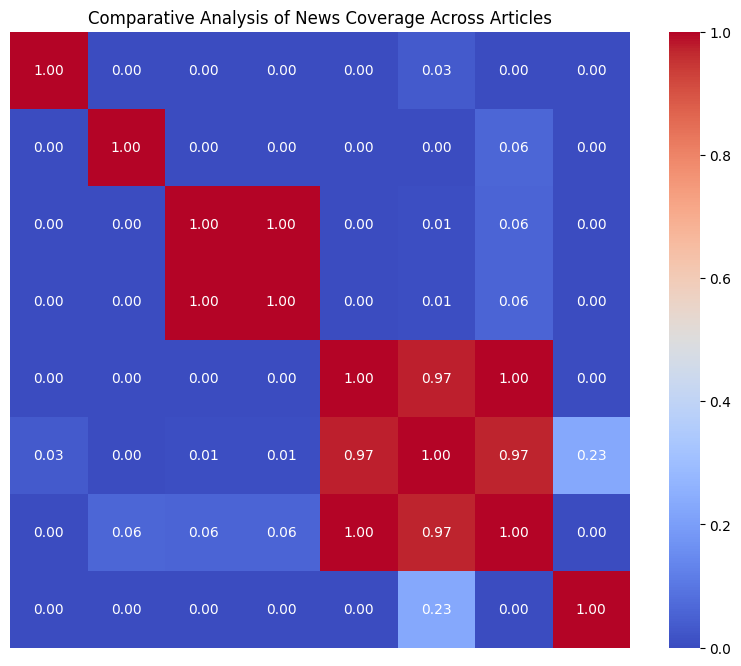

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=False, yticklabels=False)
plt.title("Comparative Analysis of News Coverage Across Articles")
plt.show()

In [29]:
print(df[['summary', 'dominant_topic', 'topic_distribution', 'similarity_scores', 'most_similar_article', 'least_similar_article']])

                                             summary  dominant_topic  \
0  An IAS officer purportedly emailed the entire ...               4   
1  It has come to light that Nona Lifestyle Priva...               2   
2  We would like to rename Zomato Ltd., the compa...               0   
3  We would like to rename Zomato Ltd., the compa...               0   
4  Zomato, a food ordering and delivery platform,...               1   
5  February 06, 2025 10:31 pm Eternal will compri...               1   
6  The company operates a B2C technology platform...               1   
7  Looks like you have exceeded the limit to book...               3   

                                  topic_distribution  similarity_scores  \
0           [0.0, 0.0, 0.0, 0.0, 0.8373272557484316]           0.129306   
1           [0.0, 0.0, 0.6570901690370965, 0.0, 0.0]           0.132438   
2           [0.8255156393641367, 0.0, 0.0, 0.0, 0.0]           0.258135   
3           [0.8255156393641367, 0.0, 0.0, 0.0, 0.0

In [30]:
comparisons = []
for i in range(len(df)):
    # Find most similar and least similar articles
    similar_idx = similarity_matrix[i].argsort()[-2]  # Most similar (excluding itself)
    least_similar_idx = similarity_matrix[i].argsort()[0]  # Least similar

    # Build comparison text
    comparison = {
        "Most Similar": f"Article {i + 1} focuses on '{topics[df['dominant_topic'][i]]}', similar to Article {similar_idx + 1} which also discusses '{topics[df['dominant_topic'][similar_idx]]}'.",
        "Least Similar": f"Article {i + 1} focuses on '{topics[df['dominant_topic'][i]]}', contrasting with Article {least_similar_idx + 1} which discusses '{topics[df['dominant_topic'][least_similar_idx]]}'."
    }
    comparisons.append(comparison)


In [31]:
df['coverage_comparison'] = comparisons

In [32]:
# Find common and unique topics
all_topics = df['dominant_topic'].tolist()
topic_counter = Counter(all_topics)
common_topics = [topics[i] for i, count in topic_counter.items() if count > 1]
unique_topics = [topics[i] for i, count in topic_counter.items() if count == 1]

topic_overlap = {
    "Common Topics": common_topics,
    "Unique Topics": unique_topics
}

In [34]:
df['sentiment_label'] = df['sentiment'].str.extract(r'(Positive|Negative|Neutral)')
sentiment_counts = df['sentiment_label'].value_counts()
if sentiment_counts.get('Positive', 0) > sentiment_counts.get('Negative', 0):
    sentiment = "Overall sentiment is positive."
elif sentiment_counts.get('Negative', 0) > sentiment_counts.get('Positive', 0):
    sentiment = "Overall sentiment is negative."
else:
    sentiment = "Overall sentiment is mixed."

In [35]:
import json
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Function to extract relevant topics using TF-IDF and similarity
def extract_relevant_topics(topics):
    if isinstance(topics, str):
        topics = ast.literal_eval(topics)  # Convert string to list if needed

    if len(topics) <= 2:
        return topics

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(topics)
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Sum similarity scores for each topic
    topic_scores = similarity_matrix.sum(axis=1)

    # Get top 2 highest scoring topics
    top_indices = topic_scores.argsort()[-2:][::-1]
    top_topics = [topics[i] for i in top_indices]

    return top_topics

# Step 1: Clean and convert topics into sets
df['top_topics'] = df['top_topics'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 2: Find common topics
topic_sets = df['top_topics'].map(set)
common_topics = set.intersection(*topic_sets)

# Step 3: Find unique topics for each row
df['unique_topics'] = df['top_topics'].map(lambda x: list(set(x) - common_topics))

# Generate coverage differences
coverage_differences = []
for _, row in df.iterrows():
    if row['most_similar_article'] in df.index and row['least_similar_article'] in df.index:
        most_similar = df.loc[row['most_similar_article']]
        least_similar = df.loc[row['least_similar_article']]

        # Extract most relevant topics for impact
        most_relevant_topics = extract_relevant_topics(row['top_topics'])
        least_relevant_topics = extract_relevant_topics(least_similar['top_topics'])

        if most_relevant_topics and least_relevant_topics:
            comparison = {
                "Comparison": f"{row['title']} highlights {', '.join(row['top_topics'])}, while {most_similar['title']} discusses {', '.join(most_similar['top_topics'])}.",
                "Impact": f"The article emphasizes {most_relevant_topics[0]} and {most_relevant_topics[1]}, contrasting with {least_relevant_topics[0]} and {least_relevant_topics[1]} in the least similar article."
            }
            coverage_differences.append(comparison)

# Format JSON output
structured_summary = {
    "Company": company_name,
    "Articles": [
        {
            "Title": row['title'],
            "Summary": row['summary'],
            "Sentiment": row['sentiment'],
            "Topics": row['top_topics'],
            "Unique Topics": row['unique_topics']
        }
        for _, row in df.iterrows()
    ],
    "Comparative Sentiment Score": {
        "Sentiment Distribution": df['sentiment'].value_counts().to_dict(),
        "Coverage Differences": coverage_differences,
        "Topic Overlap": {
            "Common Topics": list(common_topics),
            "Unique Topics": [
                {
                    "Title": row['title'],
                    "Unique Topics": row['unique_topics']
                } for _, row in df.iterrows()
            ]
        }
    },
    "Final Sentiment Analysis": f"{company_name}’s latest news coverage is mostly {df['sentiment'].mode()[0].lower()}. Potential market impact expected."
}

# Print JSON output
print(json.dumps(structured_summary, indent=4))

{
    "Company": "Zomato",
    "Articles": [
        {
            "Title": "IAS officer emails B-school alumni list over Zomato spillage issue: \u2018Need contact details of senior manager\u2019 | Trending - Hindustan Times",
            "Summary": "An IAS officer purportedly emailed the entire alumni list of a top business school over a Zomato spillage issue, requesting the contact details of a senior Zomato executive. In his email, the B-school graduate and IAS officer explained that a family member in Gurgaon experienced a spillage issue while ordering from Zomato.",
            "Sentiment": "Negative (1.0)",
            "Topics": [
                "issue, officer, spillage, school, ias",
                "session, login, expired, news, image",
                "insolvency, plea, moved, surges, tribunal"
            ],
            "Unique Topics": [
                "insolvency, plea, moved, surges, tribunal",
                "issue, officer, spillage, school, ias",
                "s

In [36]:
df

title  \
0  IAS officer emails B-school alumni list over Z...   
1  Zomato share price surges over 6% despite poss...   
2  People Matters - Interstitial Site — People Ma...   
3  People Matters - Interstitial Site — People Ma...   
4  Zomato Quick's 'Ek Do Teen' remix stops at 'Du...   
5  Latest News on Zomato: Get Zomato News Updates...   
6  Eternal Limited (ZOMATO.NS) Stock Price, News,...   
7  Zomato News: Find Zomato News Today, Latest Ne...   

                                                link                  source  \
0  https://www.hindustantimes.com/trending/ias-of...  www.hindustantimes.com   
1  https://www.indiatoday.in/business/story/zomat...       www.indiatoday.in   
2  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
3  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
4  https://www.afaqs.com/news/advertising/zomato-...           www.afaqs.com   
5            https://indianexpress.com/about/zomato/       indianexpress.com   
6         https://finance.yahoo.com/quote/ZOMATO.NS/       finance.yahoo.com   
7  https://www.livemint.com/zomato/news/companyid...        www.livemint.com   

                                        article_text  \
0  An IAS officer purportedly emailed the entire ...   
1  Listen to Story Shares of food delivery giant ...   
2  Zomato, the popular food delivery platform, is...   
3  Zomato, the popular food delivery platform, is...   
4  Zomato, a food ordering and delivery platform,...   
5  March 16, 2025 10:38 am Verma accepted that he...   
6  Eternal Limited primarily operates as an onlin...   
7  Zomato Dividend Zomato Bonus Zomato AGM Zomato...   

                                             summary        sentiment  \
0  An IAS officer purportedly emailed the entire ...   Negative (1.0)   
1  It has come to light that Nona Lifestyle Priva...  Negative (0.99)   
2  We would like to rename Zomato Ltd., the compa...   Positive (1.0)   
3  We would like to rename Zomato Ltd., the compa...   Positive (1.0)   
4  Zomato, a food ordering and delivery platform,...  Negative (0.98)   
5  February 06, 2025 10:31 pm Eternal will compri...  Positive (0.98)   
6  The company operates a B2C technology platform...  Positive (0.89)   
7  Looks like you have exceeded the limit to book...   Negative (1.0)   

                                       combined_text  \
0  IAS officer emails B-school alumni list over Z...   
1  Zomato share price surges over 6% despite poss...   
2  People Matters - Interstitial Site — People Ma...   
3  People Matters - Interstitial Site — People Ma...   
4  Zomato Quick's 'Ek Do Teen' remix stops at 'Du...   
5  Latest News on Zomato: Get Zomato News Updates...   
6  Eternal Limited (ZOMATO.NS) Stock Price, News,...   
7  Zomato News: Find Zomato News Today, Latest Ne...   

                                          top_topics  dominant_topic  \
0  [issue, officer, spillage, school, ias, sessio...               4   
1  [insolvency, plea, moved, surges, tribunal, is...               2   
2  [matters, people, eternal, core, site, issue, ...               0   
3  [matters, people, eternal, core, site, issue, ...               0   
4  [delivery, food, minute, news, quick, issue, o...               1   
5  [delivery, food, minute, news, quick, session,...               1   
6  [delivery, food, minute, news, quick, insolven...               1   
7  [session, login, expired, news, image, insolve...               3   

                                  topic_distribution  similarity_scores  \
0           [0.0, 0.0, 0.0, 0.0, 0.8373272557484316]           0.129306   
1           [0.0, 0.0, 0.6570901690370965, 0.0, 0.0]           0.132438   
2           [0.8255156393641367, 0.0, 0.0, 0.0, 0.0]           0.258135   
3           [0.8255156393641367, 0.0, 0.0, 0.0, 0.0]           0.258135   
4           [0.0, 0.5443665965374412, 0.0, 0.0, 0.0]           0.371169   
5  [0.003703786015650038, 0.5041657225643873, 0.0...  

## Final Text Output Generation

In [37]:
text_output = [f"Name of Company: {company_name}"]

for i, row in df.iterrows():
    article_entry = f"Article {i + 1}: "
    article_entry += f"{row['title']}; "
    article_entry += f"Summary: {row['summary']} This article has a {row['sentiment_label'].lower()} sentiment."
    text_output.append(article_entry)

# Print text output as array
for i, entry in enumerate(text_output):
    print(text_output[i])

Name of Company: Zomato
Article 1: IAS officer emails B-school alumni list over Zomato spillage issue: ‘Need contact details of senior manager’ | Trending - Hindustan Times; Summary: An IAS officer purportedly emailed the entire alumni list of a top business school over a Zomato spillage issue, requesting the contact details of a senior Zomato executive. In his email, the B-school graduate and IAS officer explained that a family member in Gurgaon experienced a spillage issue while ordering from Zomato. This article has a negative sentiment.
Article 2: Zomato share price surges over 6% despite possible revival of old insolvency plea - India Today; Summary: It has come to light that Nona Lifestyle Private Limited has moved the law tribunal to restore an insolvency plea that it had filed earlier against Zomato under Section 9 of the Insolvency and Bankruptcy Code (IBC) in 2024. This article has a negative sentiment.
Article 3: People Matters - Interstitial Site — People Matters; Summary: 

## Translation to Hindi

In [38]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.4 MB/s eta 0:00:00


In [39]:
from deep_translator import GoogleTranslator
from tqdm import tqdm

# Sample list of text entries to translate
text_list = ["How are you doing?", "Good morning!", "Have a nice day!"]

# Initialize the translator (source = 'auto' detects the input language)
translator = GoogleTranslator(source='en', target='hi')  # 'hi' = Hindi

In [40]:
translated_news = []
for text in tqdm(text_output, desc="Translating"):
    translated_news.append(translator.translate(text))

# Print translated results
for translated in translated_news:
    print(translated)

Translating: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]

कंपनी का नाम: ज़ोमेटो
अनुच्छेद 1: IAS अधिकारी ईमेल B-School पूर्व छात्र सूची Zomato Spillage समस्या पर: ‘वरिष्ठ प्रबंधक के संपर्क विवरण की आवश्यकता है '| ट्रेंडिंग - हिंदुस्तान टाइम्स; सारांश: एक IAS अधिकारी ने एक वरिष्ठ Zomato के कार्यकारी के संपर्क विवरण का अनुरोध करते हुए, Zomato Spillage मुद्दे पर एक शीर्ष बिजनेस स्कूल की पूरी पूर्व छात्र सूची को ईमेल किया। अपने ईमेल में, बी-स्कूल ग्रेजुएट और आईएएस अधिकारी ने बताया कि गुड़गांव में परिवार के एक सदस्य ने ज़ोमैटो से ऑर्डर करते हुए एक स्पिलेज मुद्दे का अनुभव किया। इस लेख में एक नकारात्मक भावना है।
अनुच्छेद 2: Zomato शेयर की कीमत पुरानी दिवाला याचिका के संभावित पुनरुद्धार के बावजूद 6% से अधिक बढ़ जाती है - भारत आज; सारांश: यह सामने आया है कि नोना लाइफस्टाइल प्राइवेट लिमिटेड ने एक इनसॉल्वेंसी याचिका को बहाल करने के लिए लॉ ट्रिब्यूनल को स्थानांतरित कर दिया है, जिसे उसने 2024 में इन्सॉल्वेंसी एंड दिवालियापन कोड (IBC) की धारा 9 के तहत ज़ोमाटो के खिलाफ पहले दायर किया था। इस लेख में एक नकारात्मक भावना है।
अनुच्छेद 3: लोग मायने रखते हैं - अंतर

In [41]:
hindi_news = '; '.join(translated_news)
print(hindi_news)

कंपनी का नाम: ज़ोमेटो; अनुच्छेद 1: IAS अधिकारी ईमेल B-School पूर्व छात्र सूची Zomato Spillage समस्या पर: ‘वरिष्ठ प्रबंधक के संपर्क विवरण की आवश्यकता है '| ट्रेंडिंग - हिंदुस्तान टाइम्स; सारांश: एक IAS अधिकारी ने एक वरिष्ठ Zomato के कार्यकारी के संपर्क विवरण का अनुरोध करते हुए, Zomato Spillage मुद्दे पर एक शीर्ष बिजनेस स्कूल की पूरी पूर्व छात्र सूची को ईमेल किया। अपने ईमेल में, बी-स्कूल ग्रेजुएट और आईएएस अधिकारी ने बताया कि गुड़गांव में परिवार के एक सदस्य ने ज़ोमैटो से ऑर्डर करते हुए एक स्पिलेज मुद्दे का अनुभव किया। इस लेख में एक नकारात्मक भावना है।; अनुच्छेद 2: Zomato शेयर की कीमत पुरानी दिवाला याचिका के संभावित पुनरुद्धार के बावजूद 6% से अधिक बढ़ जाती है - भारत आज; सारांश: यह सामने आया है कि नोना लाइफस्टाइल प्राइवेट लिमिटेड ने एक इनसॉल्वेंसी याचिका को बहाल करने के लिए लॉ ट्रिब्यूनल को स्थानांतरित कर दिया है, जिसे उसने 2024 में इन्सॉल्वेंसी एंड दिवालियापन कोड (IBC) की धारा 9 के तहत ज़ोमाटो के खिलाफ पहले दायर किया था। इस लेख में एक नकारात्मक भावना है।; अनुच्छेद 3: लोग मायने रखते हैं - अ

## Text To Speech

In [42]:
!pip install gtts

In [44]:
from gtts import gTTS
import os
from tqdm import tqdm

In [45]:
import io

In [46]:
def text_to_speech(text, language='hi'):
    """
    Converts text to speech and returns the MP3 as a BytesIO object.
    """
    # Generate speech
    tts = gTTS(text=text, lang=language, slow=False)

    # Store in a BytesIO object instead of saving to a file
    audio_buffer = io.BytesIO()
    tts.write_to_fp(audio_buffer)
    audio_buffer.seek(0)  # Move cursor to the beginning

    return audio_buffer  # This can be used directly in APIs or Gradio

In [47]:
hindi_news_audio = text_to_speech(hindi_news)

In [48]:
import IPython.display as ipd

# Play the audio
ipd.Audio(hindi_news_audio.getvalue(), rate=22050)

## Analysis

In [49]:
df

title  \
0  IAS officer emails B-school alumni list over Z...   
1  Zomato share price surges over 6% despite poss...   
2  People Matters - Interstitial Site — People Ma...   
3  People Matters - Interstitial Site — People Ma...   
4  Zomato Quick's 'Ek Do Teen' remix stops at 'Du...   
5  Latest News on Zomato: Get Zomato News Updates...   
6  Eternal Limited (ZOMATO.NS) Stock Price, News,...   
7  Zomato News: Find Zomato News Today, Latest Ne...   

                                                link                  source  \
0  https://www.hindustantimes.com/trending/ias-of...  www.hindustantimes.com   
1  https://www.indiatoday.in/business/story/zomat...       www.indiatoday.in   
2  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
3  https://www.peoplematters.in/news/business/zom...    www.peoplematters.in   
4  https://www.afaqs.com/news/advertising/zomato-...           www.afaqs.com   
5            https://indianexpress.com/about/zomato/       indianexpress.com   
6         https://finance.yahoo.com/quote/ZOMATO.NS/       finance.yahoo.com   
7  https://www.livemint.com/zomato/news/companyid...        www.livemint.com   

                                        article_text  \
0  An IAS officer purportedly emailed the entire ...   
1  Listen to Story Shares of food delivery giant ...   
2  Zomato, the popular food delivery platform, is...   
3  Zomato, the popular food delivery platform, is...   
4  Zomato, a food ordering and delivery platform,...   
5  March 16, 2025 10:38 am Verma accepted that he...   
6  Eternal Limited primarily operates as an onlin...   
7  Zomato Dividend Zomato Bonus Zomato AGM Zomato...   

                                             summary        sentiment  \
0  An IAS officer purportedly emailed the entire ...   Negative (1.0)   
1  It has come to light that Nona Lifestyle Priva...  Negative (0.99)   
2  We would like to rename Zomato Ltd., the compa...   Positive (1.0)   
3  We would like to rename Zomato Ltd., the compa...   Positive (1.0)   
4  Zomato, a food ordering and delivery platform,...  Negative (0.98)   
5  February 06, 2025 10:31 pm Eternal will compri...  Positive (0.98)   
6  The company operates a B2C technology platform...  Positive (0.89)   
7  Looks like you have exceeded the limit to book...   Negative (1.0)   

                                       combined_text  \
0  IAS officer emails B-school alumni list over Z...   
1  Zomato share price surges over 6% despite poss...   
2  People Matters - Interstitial Site — People Ma...   
3  People Matters - Interstitial Site — People Ma...   
4  Zomato Quick's 'Ek Do Teen' remix stops at 'Du...   
5  Latest News on Zomato: Get Zomato News Updates...   
6  Eternal Limited (ZOMATO.NS) Stock Price, News,...   
7  Zomato News: Find Zomato News Today, Latest Ne...   

                                          top_topics  dominant_topic  \
0  [issue, officer, spillage, school, ias, sessio...               4   
1  [insolvency, plea, moved, surges, tribunal, is...               2   
2  [matters, people, eternal, core, site, issue, ...               0   
3  [matters, people, eternal, core, site, issue, ...               0   
4  [delivery, food, minute, news, quick, issue, o...               1   
5  [delivery, food, minute, news, quick, session,...               1   
6  [delivery, food, minute, news, quick, insolven...               1   
7  [session, login, expired, news, image, insolve...               3   

                                  topic_distribution  similarity_scores  \
0           [0.0, 0.0, 0.0, 0.0, 0.8373272557484316]           0.129306   
1           [0.0, 0.0, 0.6570901690370965, 0.0, 0.0]           0.132438   
2           [0.8255156393641367, 0.0, 0.0, 0.0, 0.0]           0.258135   
3           [0.8255156393641367, 0.0, 0.0, 0.0, 0.0]           0.258135   
4           [0.0, 0.5443665965374412, 0.0, 0.0, 0.0]           0.371169   
5  [0.003703786015650038, 0.5041657225643873, 0.0...  

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  8 non-null      object 
 1   link                   8 non-null      object 
 2   source                 8 non-null      object 
 3   article_text           8 non-null      object 
 4   summary                8 non-null      object 
 5   sentiment              8 non-null      object 
 6   combined_text          8 non-null      object 
 7   top_topics             8 non-null      object 
 8   dominant_topic         8 non-null      int64  
 9   topic_distribution     8 non-null      object 
 10  similarity_scores      8 non-null      float64
 11  most_similar_article   8 non-null      int64  
 12  least_similar_article  8 non-null      int64  
 13  coverage_comparison    8 non-null      object 
 14  sentiment_label        8 non-null      object 
 15  unique_top

In [51]:
df.describe()

dominant_topic  similarity_scores  most_similar_article  \
count        8.000000           8.000000              8.000000   
mean         1.500000           0.262259              4.500000   
std          1.414214           0.116449              1.195229   
min          0.000000           0.129306              3.000000   
25%          0.750000           0.148333              3.750000   
50%          1.000000           0.258135              4.500000   
75%          2.250000           0.376555              5.250000   
max          4.000000           0.402544              6.000000   

       least_similar_article  
count                8.00000  
mean                 0.25000  
std                  0.46291  
min                  0.00000  
25%                  0.00000  
50%                  0.00000  
75%                  0.25000  
max                  1.00000

<ipython-input-52-da06fa5fbd98>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment_label'], palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'gray'})


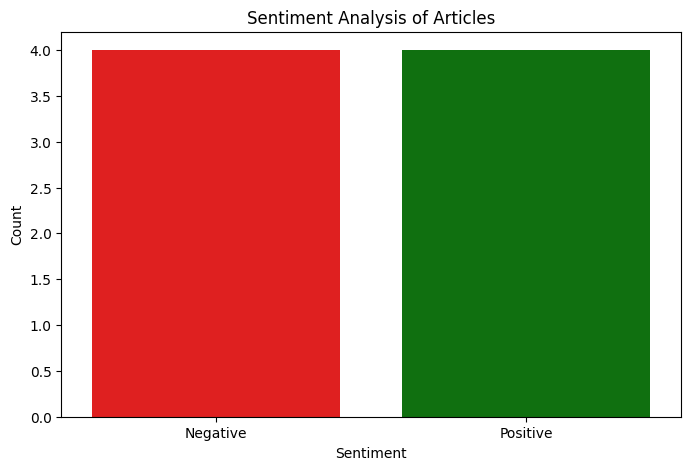

In [52]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df['sentiment_label'], palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'gray'})

plt.title("Sentiment Analysis of Articles")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

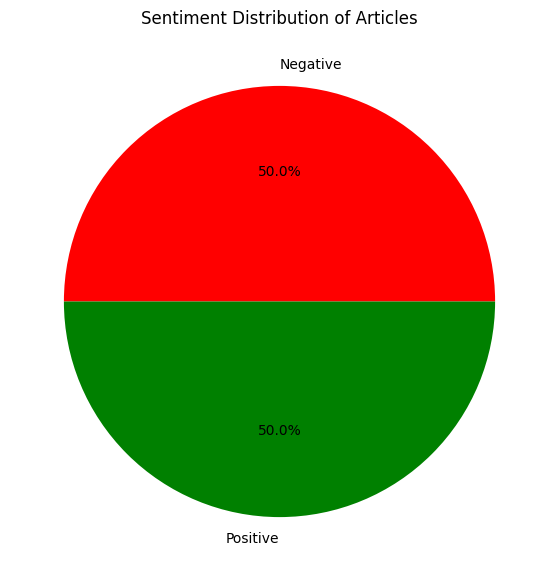

In [53]:
# Count occurrences of each sentiment label
sentiment_counts = df['sentiment_label'].value_counts()

# Define colors for each sentiment category
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'gray'}

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=[colors[label] for label in sentiment_counts.index])
plt.title("Sentiment Distribution of Articles")
plt.show()

In [55]:
df['article_length'] = df['article_text'].apply(lambda x: len(str(x)))
df['summary_length'] = df['summary'].apply(lambda x: len(str(x)))
print(df[['article_length', 'summary_length']].describe())

       article_length  summary_length
count         8.00000        8.000000
mean       1882.00000      254.625000
std         643.83982       81.071287
min         606.00000      165.000000
25%        1790.25000      208.500000
50%        1887.00000      237.000000
75%        2130.00000      291.750000
max        2815.00000      405.000000


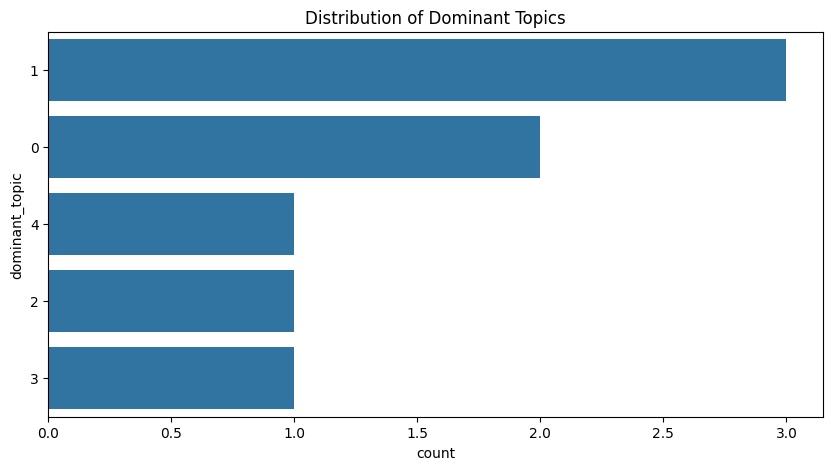

In [56]:
plt.figure(figsize=(10,5))
sns.countplot(y=df['dominant_topic'], order=df['dominant_topic'].value_counts().index)
plt.title("Distribution of Dominant Topics")
plt.show()

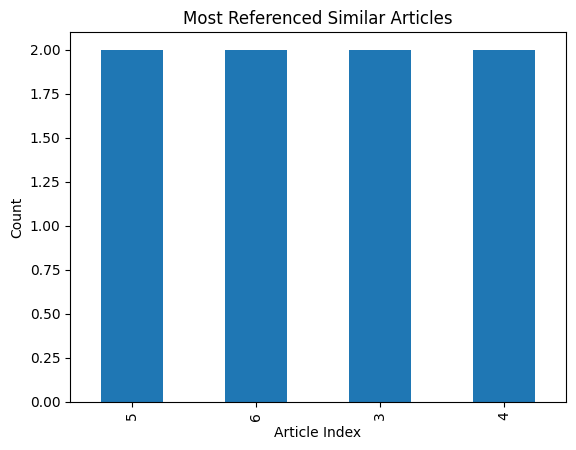

In [57]:
df['most_similar_article'].value_counts().plot(kind='bar')
plt.title("Most Referenced Similar Articles")
plt.xlabel("Article Index")
plt.ylabel("Count")
plt.show()


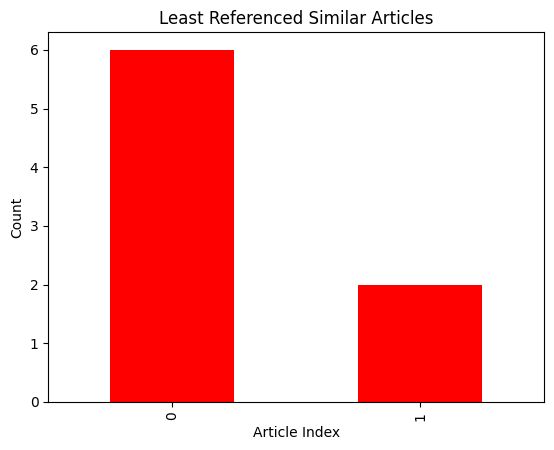

In [58]:
df['least_similar_article'].value_counts().plot(kind='bar', color='red')
plt.title("Least Referenced Similar Articles")
plt.xlabel("Article Index")
plt.ylabel("Count")
plt.show()

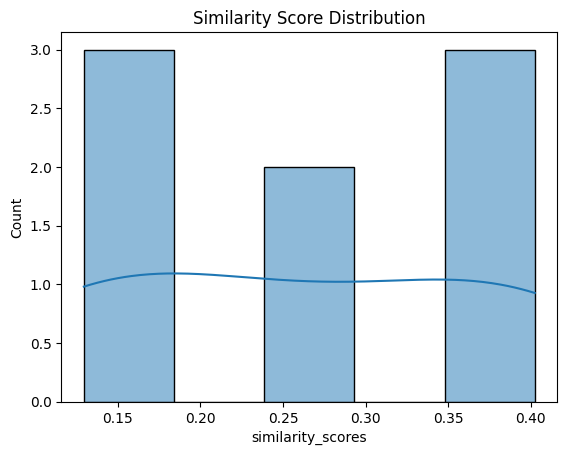

In [59]:
sns.histplot(df['similarity_scores'], bins=5, kde=True)
plt.title("Similarity Score Distribution")
plt.show()

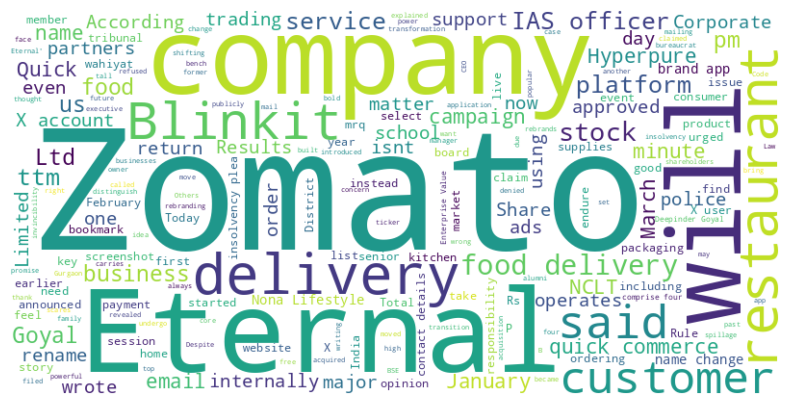

In [60]:
from wordcloud import WordCloud

text = " ".join(df['article_text'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

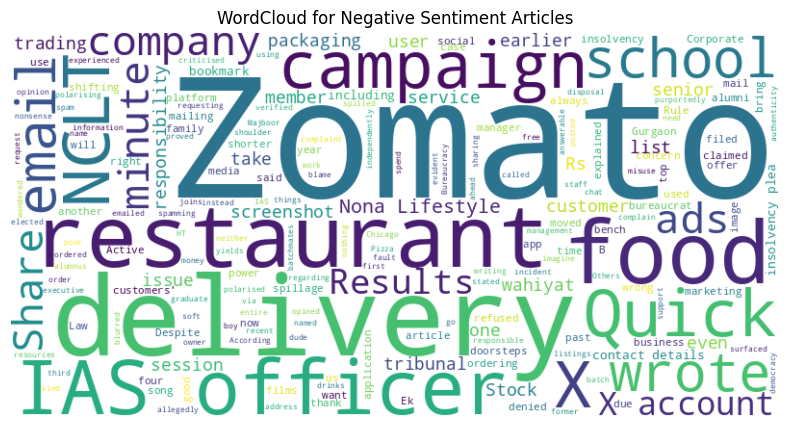

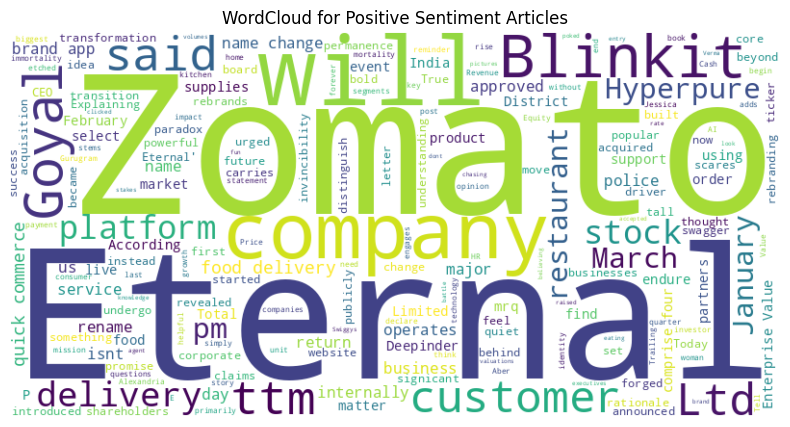

In [71]:
for sentiment in df['sentiment_label'].unique():
    text = " ".join(df[df['sentiment_label'] == sentiment]['article_text'])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {sentiment} Sentiment Articles")
    plt.show()

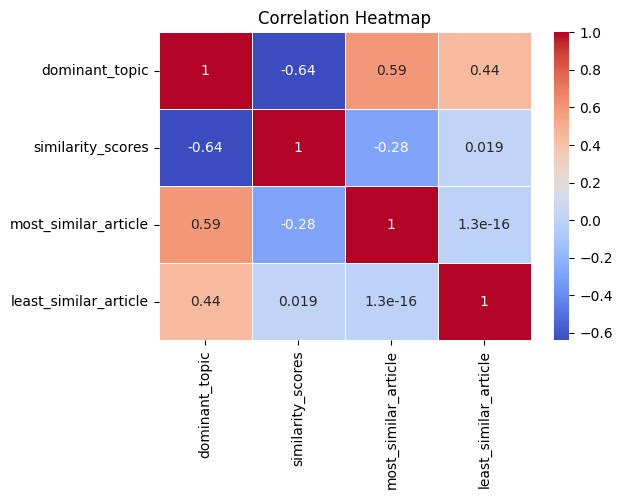

In [61]:
correlation_matrix = df[['dominant_topic', 'similarity_scores', 'most_similar_article', 'least_similar_article']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

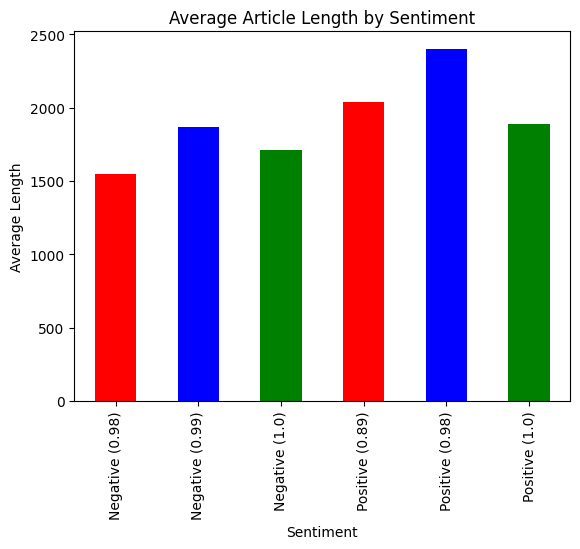

In [63]:
df.groupby("sentiment")['article_length'].mean().plot(kind='bar', color=['red', 'blue', 'green'])
plt.title("Average Article Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Length")
plt.show()

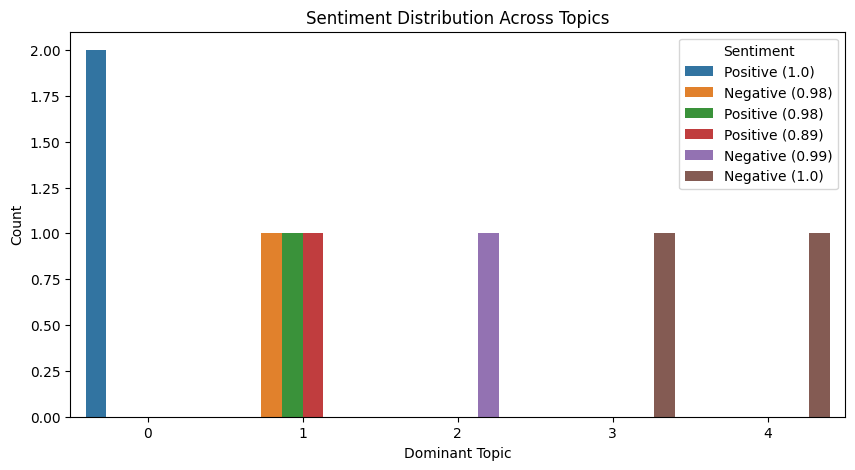

In [64]:
plt.figure(figsize=(10,5))
sns.countplot(x=df['dominant_topic'], hue=df['sentiment'])
plt.title("Sentiment Distribution Across Topics")
plt.xlabel("Dominant Topic")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.show()

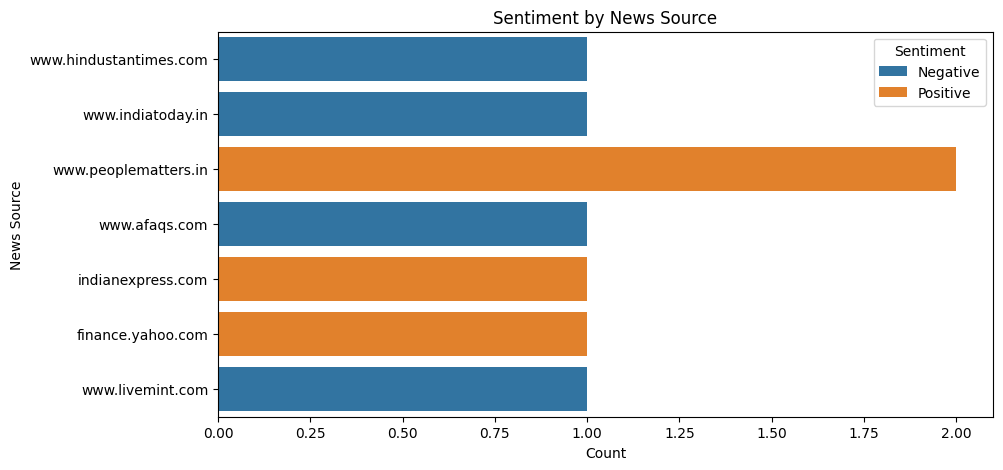

In [68]:
plt.figure(figsize=(10,5))
sns.countplot(y=df['source'], hue=df['sentiment_label'])
plt.title("Sentiment by News Source")
plt.xlabel("Count")
plt.ylabel("News Source")
plt.legend(title="Sentiment")
plt.show()